In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# AWS Lambda Tutorial #

This tutorial shows how to use our `aws_lambda` manager to execute a wrapped `node` on an AWS Labmda function. Note this requires you have AWS credentials configured. For reference, we also have a [guide](file/doc/source/developer/aws.md) in our documentation.

## Configuring Settings for AWS ##

`Podpac` settings include fields for AWS credentials and bucket information, which are empty by default. Additionally, the `Lambda` class in the `aws_lambda` manager allows developers to specify other credentials and s3 bucket information. 

Note: in either case (settings credentials in `settings` or in `aws_lambda`) the credentials being used have to match what is in `HOME/.aws/`. With that in mind, let's stick to the basic configuration for now...

You'll need to create credentials from the AWS developer console. For more information, see their [documentation](https://docs.aws.amazon.com/general/latest/gr/aws-security-credentials.html). After generating credentials, you must configure your aws cli:

```bash
aws configure # invokes prompt for credentials
# Enter credentials generated on AWS developer console
```

This will store your configuration in the `HOME/.aws/ ` directory. You can refer to that directory later to ensure `podpac.settings` has the correct credentials.

Similarly, these credentials must be configured in `podpac`:

In [2]:
import podpac
from podpac import settings
import _pickle as cPickle
# settings.S3_BUCKET_NAME = $YOUR_BUCKET_NAME
# settings.S3_JSON_FOLDER = 'json/' # Or the S3 folder you'd like JSON to be uploaded to.
# settings.S3_OUTPUT_FOLDER = 'output/' # Or the S3 folder you'd like pickle outputs to be uploaded to.
# settings.AWS_ACCESS_KEY_ID = $YOUR_ACCESS_KEY_ID
# settings.AWS_SECRET_ACCESS_KEY = $YOUR_SECRET_ACCESS_KEY
# settings.AWS_REGION_NAME = $YOUR_REGION_NAME

## SinCoords Example ##

Now that `podpac` has AWS credentials, let's go through an example, which wraps a `SinCoords` node, executes it on our Lambda function, and returns the output `UnitsDataArray`.

In [3]:
sin_coords_node = podpac.core.algorithm.algorithm.SinCoords()
coordinates = podpac.Coordinates.grid(lat=(-90, 90, 180), lon=(90,-90, 180), time='2018_01_01')

In [4]:
aws_lambda_manager = podpac.core.managers.aws_lambda.Lambda(source_node=sin_coords_node)
output = aws_lambda_manager.eval(coordinates)
output

<xarray.UnitsDataArray (lat: 180, lon: 180, time: 1)>
array([[[ 1.439804e-32],
        [ 4.126008e-18],
        ...,
        [-4.126008e-18],
        [-1.439804e-32]],

       [[ 4.126008e-18],
        [ 1.182379e-03],
        ...,
        [-1.182379e-03],
        [-4.126008e-18]],

       ...,

       [[-4.126008e-18],
        [-1.182379e-03],
        ...,
        [ 1.182379e-03],
        [ 4.126008e-18]],

       [[-1.439804e-32],
        [-4.126008e-18],
        ...,
        [ 4.126008e-18],
        [ 1.439804e-32]]])
Coordinates:
  * lat      (lat) float64 -90.0 -88.99 -87.99 -86.98 ... 86.98 87.99 88.99 90.0
  * lon      (lon) float64 90.0 88.99 87.99 86.98 ... -86.98 -87.99 -88.99 -90.0
  * time     (time) float64 2.018e+07
Attributes:
    layer_style:  <podpac.core.style.Style object at 0x000001CA1C63FB00>
    units:        None

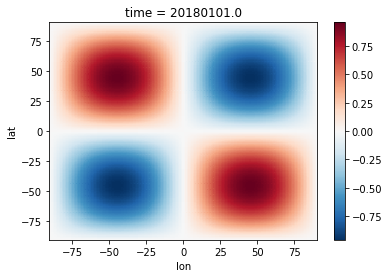

In [5]:
output.plot()

# What is the PODPAC Lambda node doing?

Let's review what `aws_lambda` is actually doing in the example above.

If we take a closer look at `Node` objects, such as `SinCoords`, we'll see a converstion concept to/from either `JSON` or an `OrderedDict`. Similarly, the `Coordinates` object can be converted to/from `JSON`. The `aws_lambda` manager also has an `Output` attribute. You guessed it - this can can be converted to/from `JSON`/`OrderedDict`.

This conversion allows the `aws_lambda` manager to take advantage of `Pipeline`, which allows the AWS `handler` to recreate the wrapped `Node`, `Coordinates`, and `Output` objects provided to the `aws_lambda` manager.

### Generating JSON to evaluate: ###
We add additional information to the node's `definition` to include the coordinates and the output type.

In [6]:
import json
from collections import OrderedDict
from podpac.core.pipeline.output import FileOutput, Output

# Create slightly different PODPAC coordinate to evaluate
coordinates = podpac.Coordinates.grid(lat=(-90, 90, 180), lon=(90,-90, 180), time='2018_01_02')

d = OrderedDict()
# Note that source_output gets created this way by default in aws_lambda.Lambda
source_output = FileOutput(node=sin_coords_node, name=sin_coords_node.__class__.__name__)
d['pipeline'] = sin_coords_node.definition
d['pipeline']['output'] = source_output.definition
d['coordinates'] = json.loads(coordinates.json)
print (json.dumps(d, indent=4))

{
    "pipeline": {
        "nodes": {
            "SinCoords": {
                "node": "core.algorithm.algorithm.SinCoords",
                "inputs": {}
            }
        },
        "output": {
            "format": "pickle",
            "mode": "file",
            "nodes": [
                "SinCoords"
            ]
        }
    },
    "coordinates": [
        {
            "start": -90.0,
            "stop": 90.0,
            "step": 1.005586592178771,
            "name": "lat",
            "coord_ref_sys": "WGS84",
            "ctype": "midpoint"
        },
        {
            "start": 90.0,
            "stop": -90.0,
            "step": -1.005586592178771,
            "name": "lon",
            "coord_ref_sys": "WGS84",
            "ctype": "midpoint"
        },
        {
            "values": [
                20180102.0
            ],
            "name": "time",
            "coord_ref_sys": "WGS84",
            "ctype": "midpoint"
        }
    ]
}


### Uploading JSON to S3 ###

This JSON should now be uploaded to S3, which will trigger the evaluation of the node using the AWS Lambda function that we set up recently.

In [7]:
import boto3
s3 = boto3.client('s3')
file_key = settings.S3_JSON_FOLDER + source_output.name + '.json' # We'll want this later.
s3.put_object(
    Body=(bytes(json.dumps(d, indent=4).encode('UTF-8'))),
    Bucket=settings.S3_BUCKET_NAME,
    Key=file_key
)

{'ETag': '"c4293e8a118913a8f0c9b995c40abbb6"',
 'ResponseMetadata': {'HTTPHeaders': {'content-length': '0',
   'date': 'Wed, 31 Oct 2018 19:40:08 GMT',
   'etag': '"c4293e8a118913a8f0c9b995c40abbb6"',
   'server': 'AmazonS3',
   'x-amz-id-2': 'Cgz2L6jozr42stf05LLrgCox7QZsbV43TZXSMmRLIv8zTy0jzr2l4yd3FvjqZoNP54IC+X//C2o=',
   'x-amz-request-id': '7E92523F994A8637'},
  'HTTPStatusCode': 200,
  'HostId': 'Cgz2L6jozr42stf05LLrgCox7QZsbV43TZXSMmRLIv8zTy0jzr2l4yd3FvjqZoNP54IC+X//C2o=',
  'RequestId': '7E92523F994A8637',
  'RetryAttempts': 0}}

#### Wait for file output to appear in the S3 output bucket ####

For the `aws_lambda` manager to return an output, it needs to wait for the AWS Lambda function to evaluate. This cell will not finish until the AWS Lambda function has uploaded the output to S3.

In [8]:
from io import BytesIO
waiter = s3.get_waiter('object_exists')
filename = '%s.%s' % (
    source_output.name,
    source_output.format)
waiter.wait(Bucket=settings.S3_BUCKET_NAME, Key=settings.S3_OUTPUT_FOLDER +
            filename)
# After waiting, load the pickle file like this:
resource = boto3.resource('s3')
with BytesIO() as data:
    # Get the bucket and file name programmatically - see above...
    resource.Bucket(settings.S3_BUCKET_NAME).download_fileobj(settings.S3_OUTPUT_FOLDER +
            filename, data)
    data.seek(0)    # move back to the beginning after writing
    output = cPickle.load(data)
output

<xarray.UnitsDataArray (lat: 180, lon: 180, time: 1)>
array([[[ 1.439804e-32],
        [ 4.126008e-18],
        ...,
        [-4.126008e-18],
        [-1.439804e-32]],

       [[ 4.126008e-18],
        [ 1.182379e-03],
        ...,
        [-1.182379e-03],
        [-4.126008e-18]],

       ...,

       [[-4.126008e-18],
        [-1.182379e-03],
        ...,
        [ 1.182379e-03],
        [ 4.126008e-18]],

       [[-1.439804e-32],
        [-4.126008e-18],
        ...,
        [ 4.126008e-18],
        [ 1.439804e-32]]])
Coordinates:
  * lat      (lat) float64 -90.0 -88.99 -87.99 -86.98 ... 86.98 87.99 88.99 90.0
  * lon      (lon) float64 90.0 88.99 87.99 86.98 ... -86.98 -87.99 -88.99 -90.0
  * time     (time) float64 2.018e+07
Attributes:
    layer_style:  <podpac.core.style.Style object at 0x000001CA1C82EB70>
    units:        None

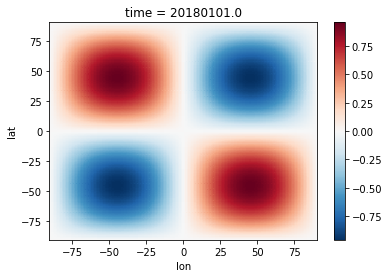

In [9]:
# Show the output that we get in Python
output.plot()

# What is the AWS Lambda function doing?

The AWS Lambda function has a PODPAC `handler.py` module, which uses the information in the `JSON` uploaded to S3 to evaluate a PODPAC `Pipeline` node, then uploads that file output back to S3.

#### Reading the JSON from S3: ####

In [10]:
# NOTE:
# The handler would parse S3 object metadata from the S3 trigger like this:
# bucket_name = event['Records'][0]['s3']['bucket']['name']
# file_key = urllib.unquote_plus(
#     event['Records'][0]['s3']['object']['key'])
# _json = ''
#
# However, we don't need to do that for this example:

file_key = settings.S3_JSON_FOLDER + source_output.name + '.json'
s3_json = ''
obj = s3.get_object(Bucket=settings.S3_BUCKET_NAME, Key=file_key)
# get lines
lines = obj['Body'].read().split(b'\n')
for r in lines:
    if len(s3_json) > 0:
        s3_json += '\n'
    s3_json += r.decode()
s3_json = json.loads(s3_json, object_pairs_hook=OrderedDict)
print(json.dumps(s3_json, indent=4)) # This should display a similar (different date) json string as earlier.

{
    "pipeline": {
        "nodes": {
            "SinCoords": {
                "node": "core.algorithm.algorithm.SinCoords",
                "inputs": {}
            }
        },
        "output": {
            "format": "pickle",
            "mode": "file",
            "nodes": [
                "SinCoords"
            ]
        }
    },
    "coordinates": [
        {
            "start": -90.0,
            "stop": 90.0,
            "step": 1.005586592178771,
            "name": "lat",
            "coord_ref_sys": "WGS84",
            "ctype": "midpoint"
        },
        {
            "start": 90.0,
            "stop": -90.0,
            "step": -1.005586592178771,
            "name": "lon",
            "coord_ref_sys": "WGS84",
            "ctype": "midpoint"
        },
        {
            "values": [
                20180102.0
            ],
            "name": "time",
            "coord_ref_sys": "WGS84",
            "ctype": "midpoint"
        }
    ]
}


#### Evaluating the pipeline

In [11]:
# Get the JSON definition
pipeline_json = s3_json['pipeline']

# Create PODPAC node from the JSON definition
pipeline = podpac.core.pipeline.Pipeline(definition=pipeline_json, do_write_output=False) # Don't write the file locally - will upload to S3

# Create PODPAC coordinates from the JSON definition
coords = podpac.Coordinates.from_json(
    json.dumps(s3_json['coordinates'], indent=4))

# Evaluate the node
output = pipeline.eval(coords)

# Let's display the output as it exists on the AWS Lambda function
output

<xarray.UnitsDataArray (lat: 180, lon: 180, time: 1)>
array([[[-3.218299e-34],
        [-9.222597e-20],
        ...,
        [ 9.222597e-20],
        [ 3.218299e-34]],

       [[-9.222597e-20],
        [-2.642896e-05],
        ...,
        [ 2.642896e-05],
        [ 9.222597e-20]],

       ...,

       [[ 9.222597e-20],
        [ 2.642896e-05],
        ...,
        [-2.642896e-05],
        [-9.222597e-20]],

       [[ 3.218299e-34],
        [ 9.222597e-20],
        ...,
        [-9.222597e-20],
        [-3.218299e-34]]])
Coordinates:
  * lat      (lat) float64 -90.0 -88.99 -87.99 -86.98 ... 86.98 87.99 88.99 90.0
  * lon      (lon) float64 90.0 88.99 87.99 86.98 ... -86.98 -87.99 -88.99 -90.0
  * time     (time) float64 2.018e+07
Attributes:
    layer_style:  <podpac.core.style.Style object at 0x000001CA1C8E6550>
    units:        None

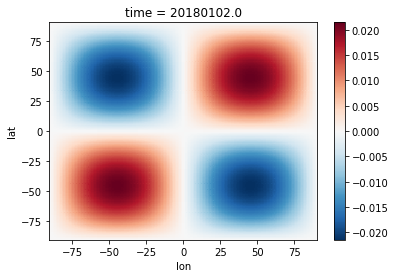

In [12]:
# Show the output that we get on the AWS Lambda function
output.plot()

### Uploading the result back to S3 ###
This is the final step on the AWS Lambda function. Our local PODPAC node that originally made the request to trigger the AWS Lambda function would be waiting for this file to appear in the output bucket.  

In [13]:
filename = '%s.%s' % (
    pipeline.pipeline_output.name,
    pipeline.pipeline_output.format)
body = cPickle.dumps(pipeline._output)
s3.put_object(Bucket=settings.S3_BUCKET_NAME,
              Key=settings.S3_OUTPUT_FOLDER + filename, Body=body)

{'ETag': '"0424884b6446b57e0ebaaae96ac9c206"',
 'ResponseMetadata': {'HTTPHeaders': {'content-length': '0',
   'date': 'Wed, 31 Oct 2018 19:40:09 GMT',
   'etag': '"0424884b6446b57e0ebaaae96ac9c206"',
   'server': 'AmazonS3',
   'x-amz-id-2': '+w0N1q+yKOKKUUUTRtLcHeQ/5SKYcN4PXrwEAHcTirJQg7bflBdMhUzg+FSSzgGkNteC9b4eRcY=',
   'x-amz-request-id': '75B119997A157EB9'},
  'HTTPStatusCode': 200,
  'HostId': '+w0N1q+yKOKKUUUTRtLcHeQ/5SKYcN4PXrwEAHcTirJQg7bflBdMhUzg+FSSzgGkNteC9b4eRcY=',
  'RequestId': '75B119997A157EB9',
  'RetryAttempts': 0}}